# Titanic, Machine Learning from Disaster

데이터 출처 : https://www.kaggle.com/c/titanic

The competition is simple : use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

Using the patterns you find in the train.csv data, predict whether the other passengers on board (found in test.csv) survived.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 결측치를 시각적으로 확인
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

In [2]:
## 한글 폰트 설정
import os
os.name

if os.name == 'posix' :
    plt.rc('font', family='AppleGothic')    # 맥
else :
    plt.rc('font', family='Malgun Gothic')  # 윈도우

# 마이너스 폰트 깨지는 문제에 대한 대처
plt.rc('axes', unicode_minus=False)

# 레티나 설정을 해주면 글씨가 더 선명해짐
%config InlineBackend.figure_font = 'retina'

# 1. 데이터셋 확인

In [3]:
# train 데이터
df_train = pd.read_csv("train.csv")

print(df_train.shape)
df_train.head(3)

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
## test 데이터

# The test dataset contains similar information but does not disclose the “ground truth” for each passenger
# It’s your job to predict these outcomes.
df_test = pd.read_csv("test.csv")

print(df_test.shape)
df_test.head(3)

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [5]:
# 변수 정보
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


변수 정보
- PassengerId : 탑승ID
- Survived : 생존 여부 (0 = No, 1 = Yes)
- Pclass : Ticket Class (1 = 1st, 2 = 2nd, 3 = 3rd)
- Name : 이름
- Sex : 성별
- Age : 나이
- SibSp : 함께 탑승한 형제, 배우자 수
- Parch : 함께 탑승한 부모, 자식 수
- Ticket : 티켓 번호
- Fare : 탑승료
- Cabin : 객실 번호
- Embarked : 탑승 항구 (C = Cherbourg, Q = Queenstown, S = Southampton)

In [7]:
# 수치 데이터 확인
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


## 1.1 Null값 확인

In [9]:
# df_train
df_train.isna().sum() / len(df_train) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [10]:
# df_test
df_test.isna().sum() / len(df_test) * 100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

<Axes: >

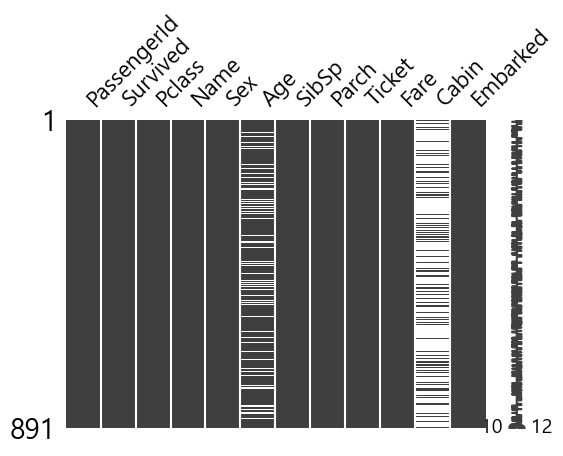

In [11]:
## 결측치 시각화

# 방법 1
msno.matrix(df=df_train, figsize=(6, 4))

<Axes: >

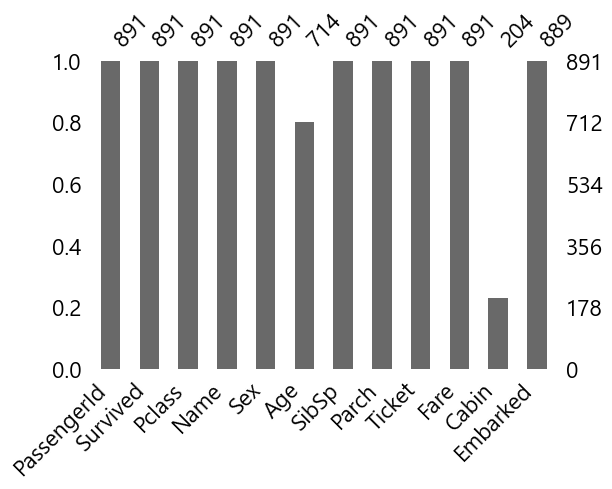

In [12]:
# 방법 2
msno.bar(df=df_train, figsize=(6, 4))

<Axes: >

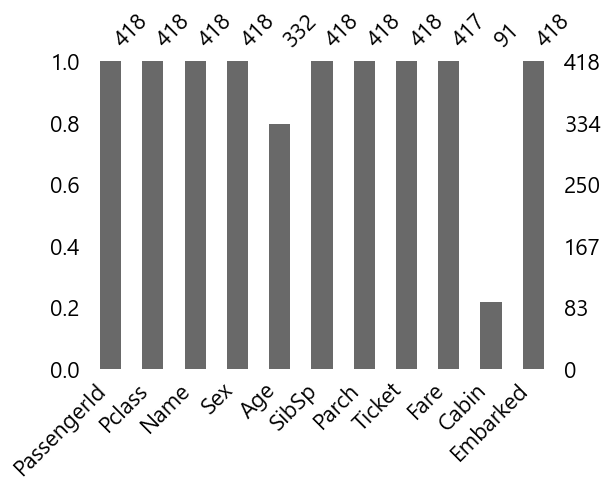

In [13]:
msno.bar(df=df_test, figsize=(6, 4))

## 1.2 종속 변수 확인

In [14]:
# 종속변수 분포비
df_train['Survived'].value_counts() / len(df_train) * 100

Survived
0    61.616162
1    38.383838
Name: count, dtype: float64

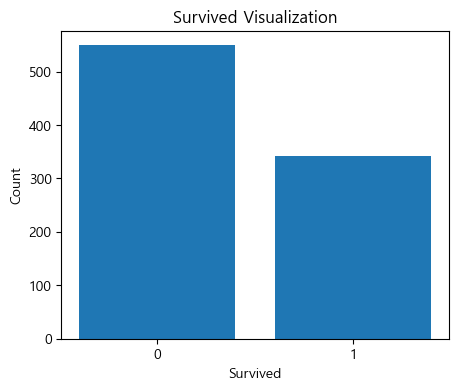

In [15]:
survive = df_train['Survived'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(5, 4))

ax.bar(survive.index, survive.values)
ax.set_xlabel('Survived')
ax.set_ylabel('Count')

ax.set_xticks([0, 1])

plt.title('Survived Visualization')
plt.show()

종속 변수가 비교적 균일한 편

# 2. EDA (Exploratory Data Analysis)

## 2.1 Pclass : 카테고리이면서 순서가 있는 데이터

In [16]:
# Pclass별 탑승 인원
df_train[['Pclass', 'Survived']].groupby('Pclass').count()

,Survived
Pclass,
1,216
2,184
3,491


In [17]:
# Pclass별 생존자
df_train[['Pclass', 'Survived']].groupby('Pclass').sum()

,Survived
Pclass,
1,136
2,87
3,119


In [18]:
## Pclass별 사망자 vs 생존자

# margins=True : 행과 열의 합계 추가
pd.crosstab(df_train['Pclass'], df_train['Survived'], margins=True).style.background_gradient(cmap='GnBu')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


<Axes: xlabel='Pclass'>

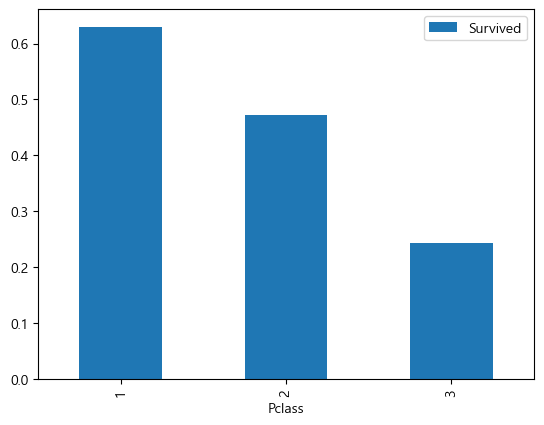

In [19]:
# Pclass별 생존률
display(df_train[['Pclass', 'Survived']].groupby('Pclass').mean())

df_train[['Pclass', 'Survived']].groupby('Pclass').mean().plot.bar()

Text(0, 0.5, 'Count')

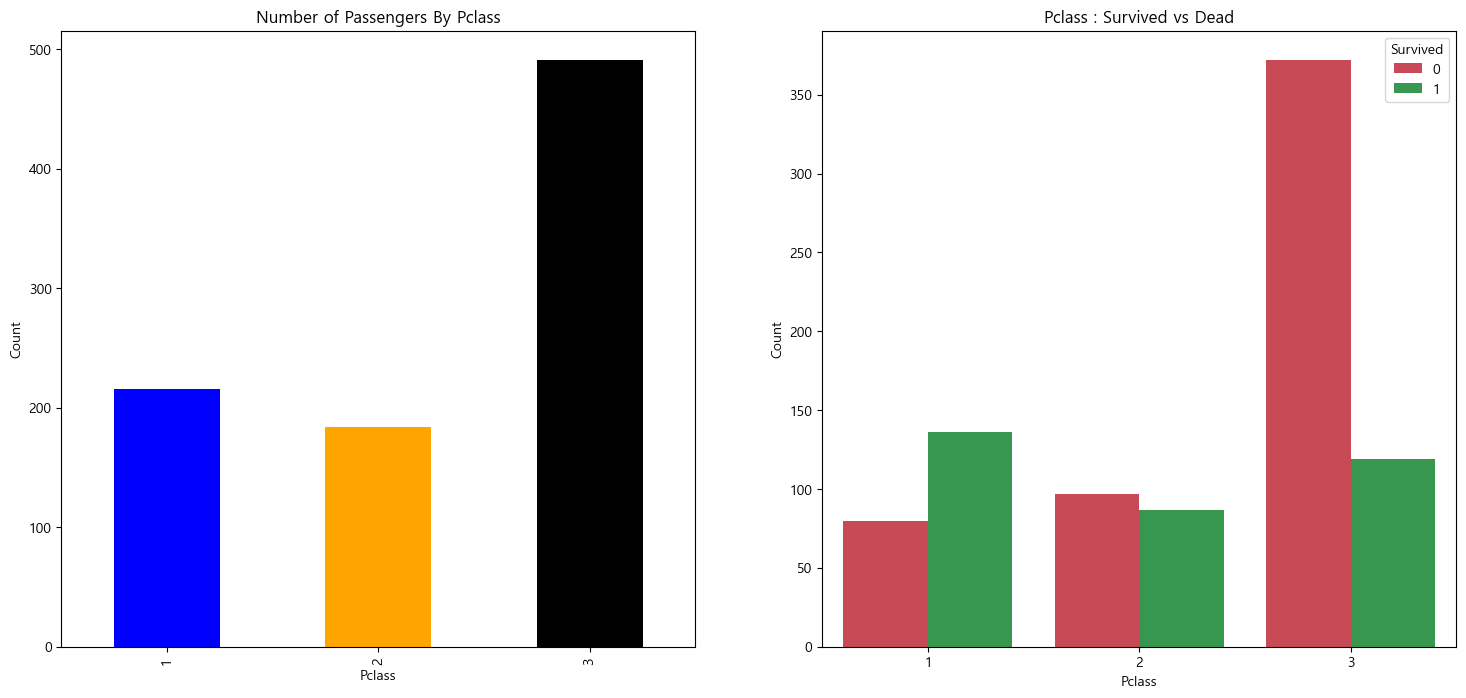

In [20]:
# 시각화

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Pclass'].value_counts().sort_index().plot.bar(color=['blue', 'orange', 'black'], ax=ax[0])
ax[0].set_title('Number of Passengers By Pclass')
ax[0].set_ylabel('Count')

sns.countplot(data=df_train, x='Pclass', hue='Survived', palette = ['#dc3545', '#28a745'], ax=ax[1])
ax[1].set_title('Pclass : Survived vs Dead')
ax[1].set_ylabel('Count')

Pclass 요약
- Pclass가 높을수록 생존률이 높음
- 생존률 : Pclass 순서대로 63%, 47%, 24%
- 생존에 Pclass가 큰 영향을 미친다고 생각할 수 있음 → 모델 생성시 Pclass 변수를 사용하는 것이 좋음

## 2.2 Sex

In [21]:
# Sex별 생존률
df_train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


In [22]:
# Sex별 생존자 vs 사망자
pd.crosstab(df_train['Sex'], df_train['Survived'], margins=True).style.background_gradient(cmap='GnBu')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


Text(0, 0.5, 'Count')

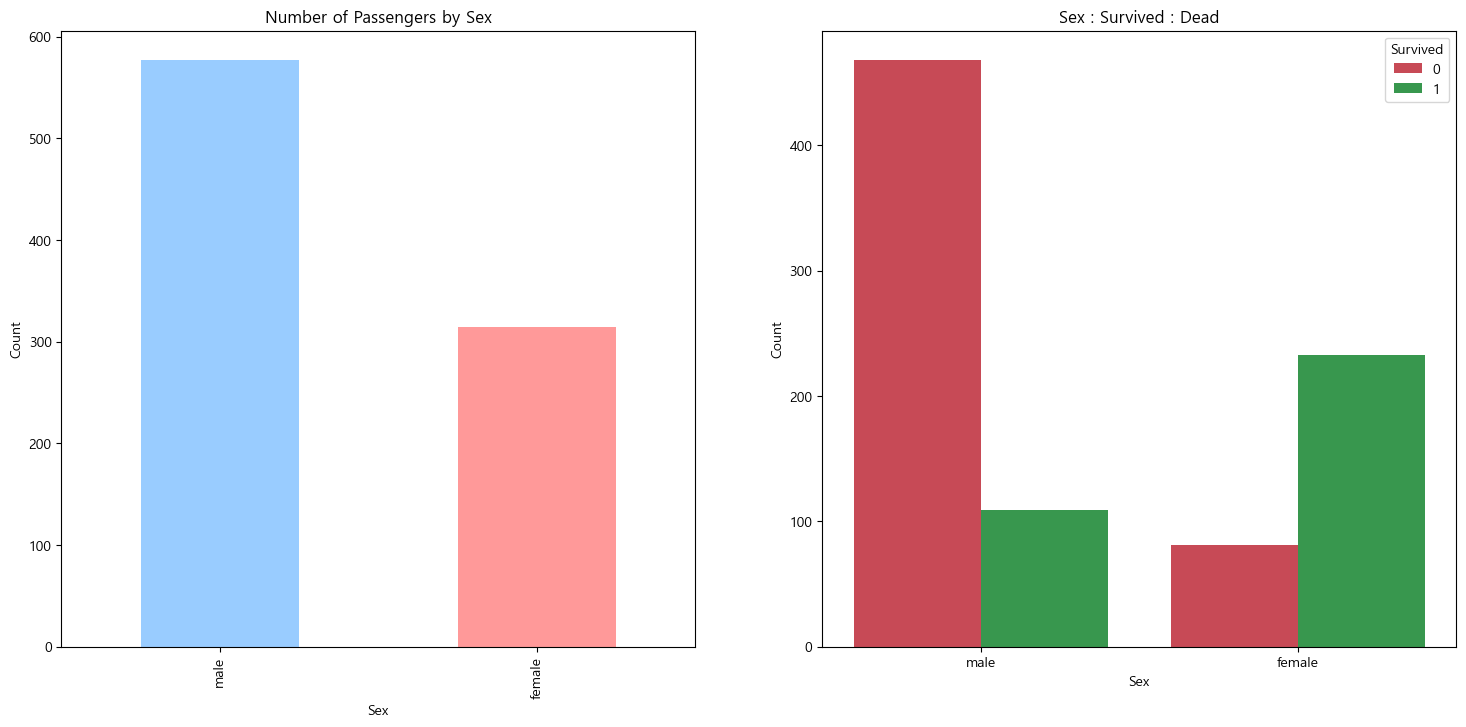

In [23]:
# 시각화

fig, ax = plt.subplots(1, 2, figsize=(18, 8))

df_train['Sex'].value_counts().plot.bar(color=['#99ccff', '#ff9999'], ax=ax[0])
ax[0].set_title('Number of Passengers by Sex')
ax[0].set_ylabel('Count')

sns.countplot(data=df_train, x='Sex', hue='Survived', palette = ['#dc3545', '#28a745'], ax=ax[1])
ax[1].set_title('Sex : Survived : Dead')
ax[1].set_ylabel('Count')

Sex 요약
- Female의 생존확률이 더 높음
- 생존률 : Male, Female 순서대로 19%, 74%

## 2.3 Pclass & Sex

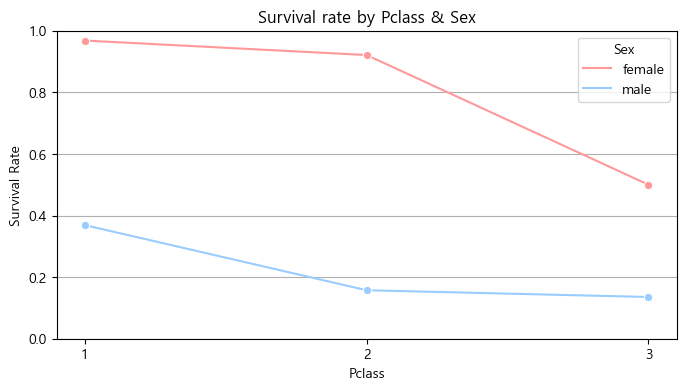

In [24]:
## 시각화

# 생존 비율 계산
survival_rate = df_train.groupby(['Pclass', 'Sex'])['Survived'].mean().reset_index()

plt.subplots(figsize=(8, 4))
sns.lineplot(data=survival_rate, x='Pclass', y='Survived', hue='Sex', palette = ['#ff9999', '#99ccff'], marker='o')

plt.title('Survival rate by Pclass & Sex')
plt.ylabel('Survival Rate')
plt.xticks([1, 2, 3])
plt.ylim(0, 1)  # y축 범위 조정
plt.grid(axis='y')
plt.show()

Pclass & Sex 요약
- 모든 Pclass에서 Female이 살 확률이 Male보다 높음
- Sex에 상관없이 Pclass가 높을수록 생존률이 높음

## 2.4 Age

In [25]:
# 데이터 확인
print('나이가 제일 어린 탑승객 나이 : %s' % df_train['Age'].min())
print('나이가 제일 많은 탑승객 나이 : %s' % df_train['Age'].max())
print('평균 탑승객 나이 : {:.2f}'.format(df_train['Age'].mean()))

나이가 제일 어린 탑승객 나이 : 0.42
나이가 제일 많은 탑승객 나이 : 80.0
평균 탑승객 나이 : 29.70


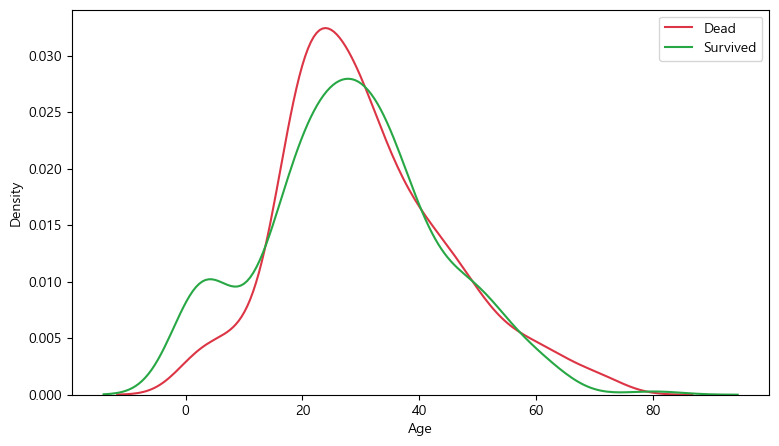

In [26]:
## 연령별 Survived vs Dead
fig, ax = plt.subplots(figsize=(9, 5))

# 커널 밀도 추정 (Kernel Density Estimation)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], color='#dc3545')
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], color='#28a745')

plt.legend(['Dead', 'Survived'])
plt.show()

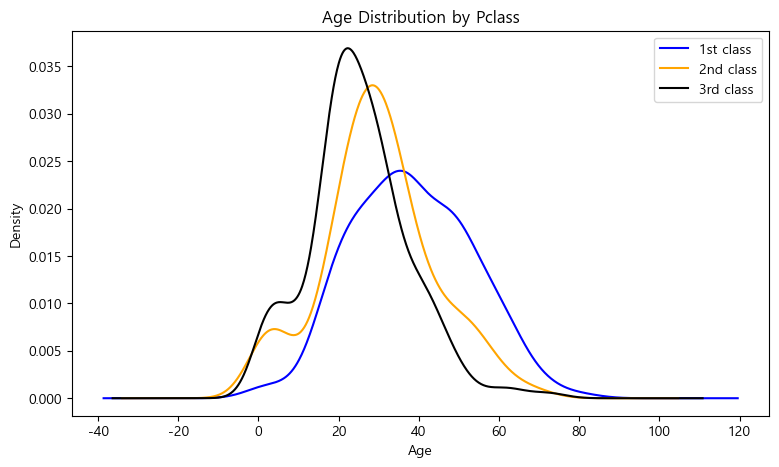

In [27]:
## Pclass별 연령대 시각화
fig, ax = plt.subplots(figsize=(9, 5))

df_train['Age'][df_train['Pclass'] == 1].plot(kind='kde', color='blue')
df_train['Age'][df_train['Pclass'] == 2].plot(kind='kde', color='orange')
df_train['Age'][df_train['Pclass'] == 3].plot(kind='kde', color='black')

plt.title('Age Distribution by Pclass')
plt.xlabel('Age')
plt.legend(['1st class', '2nd class', '3rd class'])
plt.show()

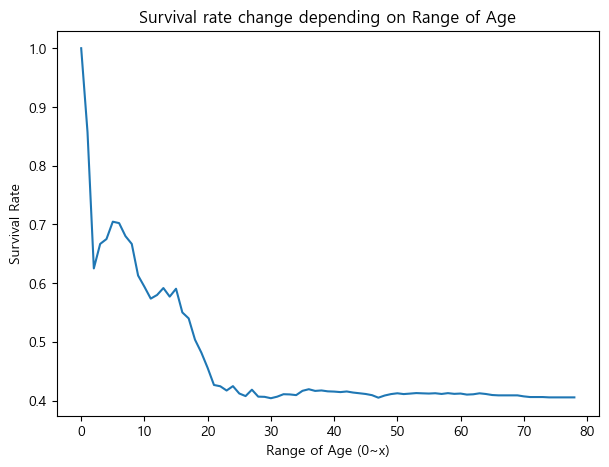

In [28]:
## Age별 누적 생존률

## 그래프 해석
# 10세 이하 탑승객이 생존할 확률 = 약 58%
# 80세 이사 탑승객이 생존할 확률 (탑승객 전원) = 약 40%

cumulative_survival_rate = []

for i in range(1, 80) :     # 초고령 탑승자 나이 = 80살
    cumulative_survival_rate.append(df_train[df_train['Age'] < i]['Survived'].sum()
                                    / len(df_train[df_train['Age'] < i]['Survived']))

plt.figure(figsize=(7, 5))
plt.plot(cumulative_survival_rate)

plt.title('Survival rate change depending on Range of Age')
plt.xlabel('Range of Age (0~x)')
plt.ylabel('Survival Rate')
plt.show()

Age 요약
- 생존자 중 나이가 어린 탑승객이 많음
- Pclass가 높을수록 나이가 많은 탑승객 수가 많아짐
- 나이가 어릴수록 생존확률이 높음 → 모델 생성시 Age 변수를 사용하는 것이 좋음

## 2.5 Pclass & Sex & Age

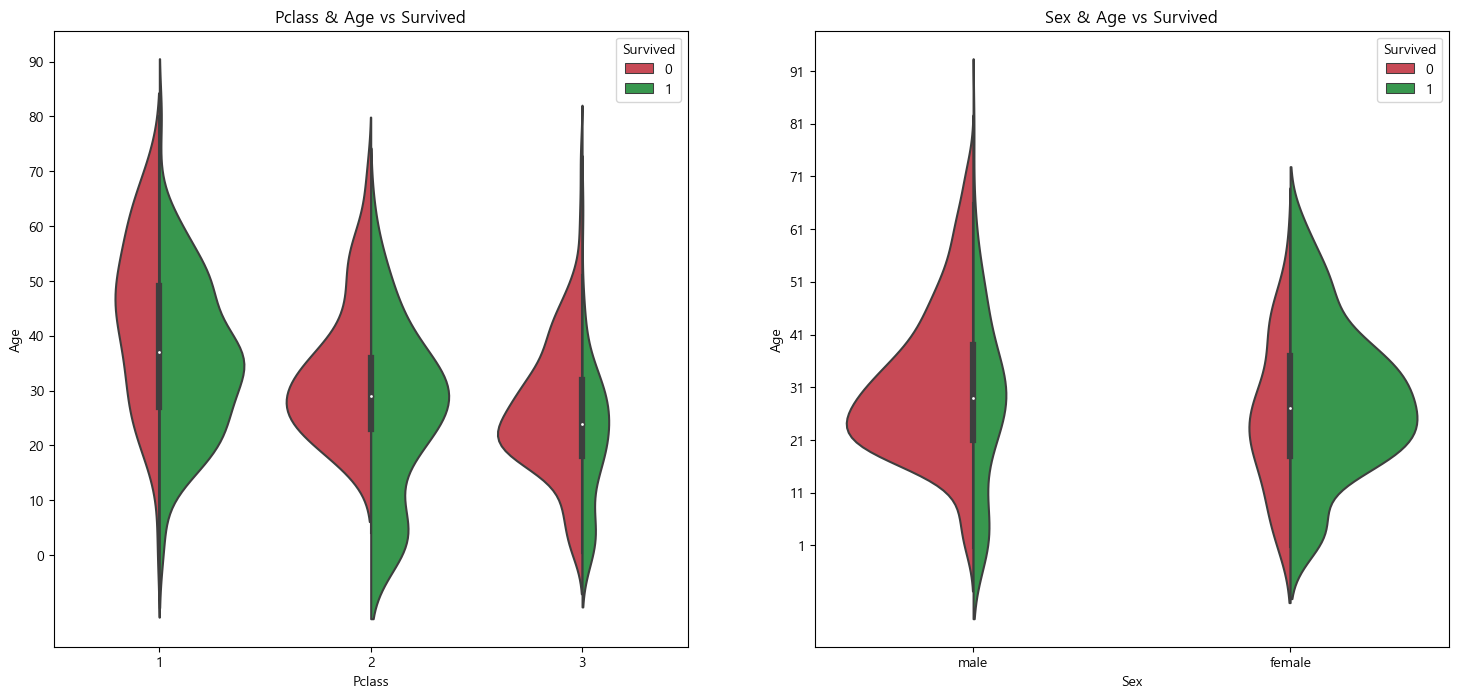

In [29]:
## Violineplot시각화
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

# scale='count' : violine의 너비를 데이터 개수에 따라 조절
# split=True : hue 변수에 따라 Violine 분할
sns.violinplot(data=df_train, x='Pclass', y='Age', hue='Survived', palette = ['#dc3545', '#28a745'], scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass & Age vs Survived')
ax[0].set_yticks(range(0, 100, 10))

sns.violinplot(data=df_train, x='Sex', y='Age', hue='Survived', palette=['#dc3545', '#28a745'], scale='count', split=True, ax=ax[1])
ax[1].set_title('Sex & Age vs Survived')
ax[1].set_yticks(range(1, 100, 10))

plt.show()

Pclass & Sex & Age 요약
- 생존만 봤을 때, 모든 Pclass에서 나이가 어릴수록 생존이 많음
- Figure (1) : female이 많이 생존
- 즉, 여성과 아이를 먼저 챙김

## 2.6 Embarked

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


<Axes: xlabel='Embarked'>

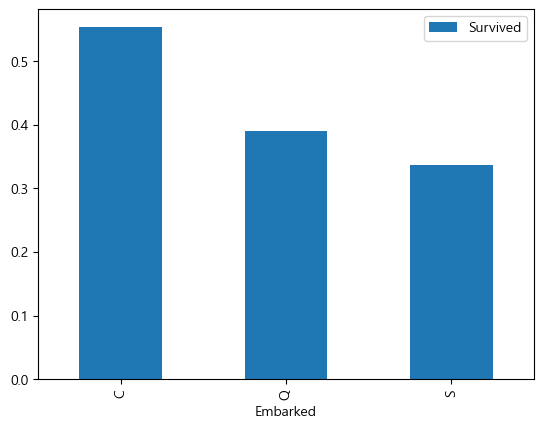

In [30]:
# 탑승 항구별 생존률
display(df_train[['Embarked', 'Survived']].groupby('Embarked').mean())
df_train[['Embarked', 'Survived']].groupby('Embarked').mean().plot.bar()

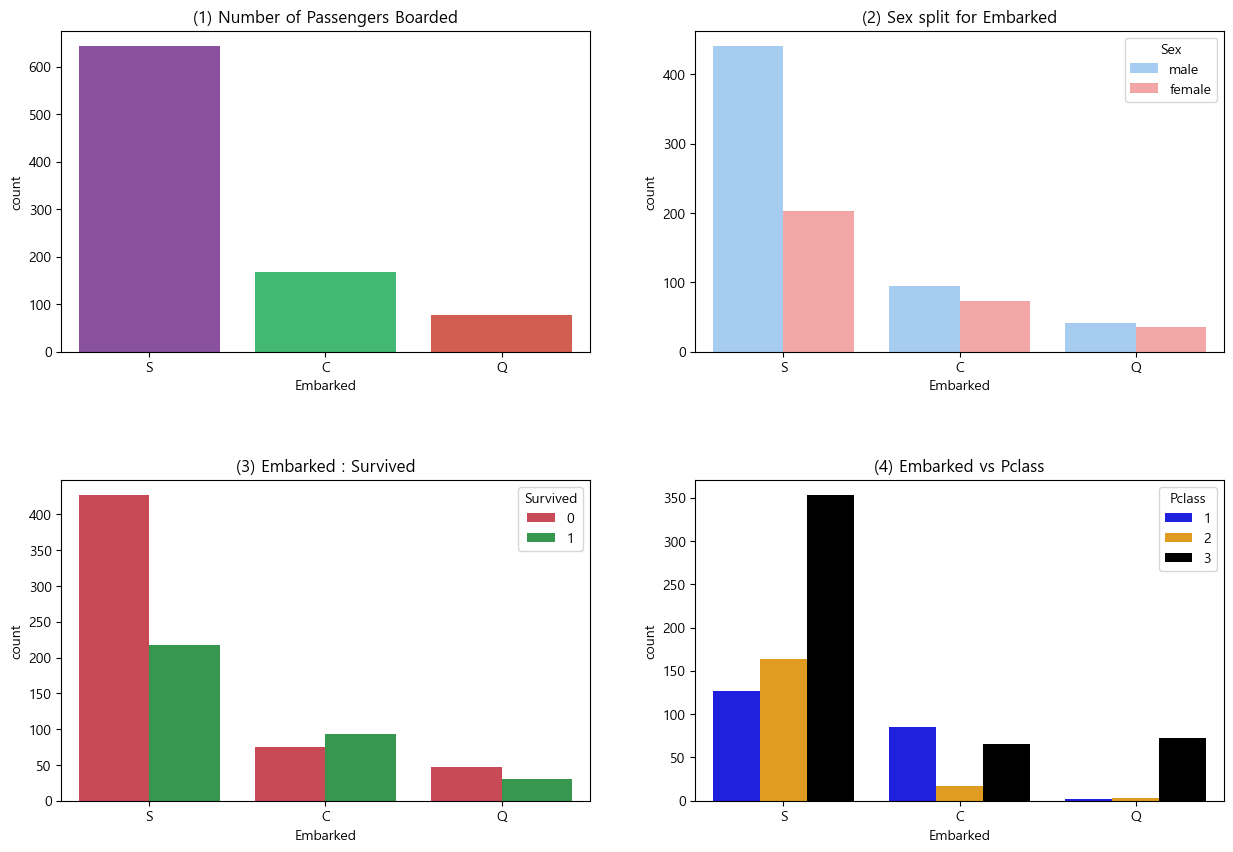

In [31]:
## 시각화
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sns.countplot(data=df_train, x='Embarked', palette=["#8E44AD", "#2ECC71", "#E74C3C"], ax=ax[0, 0])
ax[0][0].set_title('(1) Number of Passengers Boarded')

sns.countplot(data=df_train, x='Embarked', hue='Sex', palette=['#99ccff', '#ff9999'], ax=ax[0, 1])
ax[0][1].set_title('(2) Sex split for Embarked')

sns.countplot(data=df_train, x='Embarked', hue='Survived', palette=['#dc3545', '#28a745'], ax=ax[1,0])
ax[1][0].set_title('(3) Embarked : Survived')

sns.countplot(data=df_train, x='Embarked', hue='Pclass', palette=['blue', 'orange', 'black'], ax=ax[1, 1])
ax[1][1].set_title('(4) Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.4) # subplots간의 가로/세로 간격 조정
plt.show()

Embarked 요약
- 생존률은 비슷하지만 C (Cherbourg)가 제일 높음 → 모델에 큰 영향력을 미칠까?
- Figure 1 : S (Southampton)에서 가장 많은 사람이 탑승
- Figure 2 : Q (Queenstowm)과 C는 남녀 비율이 비슷하고, S는 남자가 더 많음
- Figure 3 : S의 생존률이 가장 낮음 (이전 그래프에서도 확인 가능)
- Figure 4 : C의 생존 확률이 높은 이유는 Pclass가 높은 사람들이 많이 탐. S는 Pclass가 낮은 사람들이 많이 타서 생존 확률이 낮음

## 2.7 Fmily = SiSp(형제, 배우자) + Parch(부모, 자녀)

In [32]:
# 확인
# 즉, df_train는 unique한 탑승객 정보가 담김
print('전체 탑승객 수 : %s 명' % len(df_train))
print('유니크한 Name 개수 : %s 명' % df_train['Name'].nunique())

전체 탑승객 수 : 891 명
유니크한 Name 개수 : 891 명


In [33]:
## 새로운 열 생성 (Family = SiSp + Parch)
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 본인 포함
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

print('FamilySize의 최솟값 : ', df_train['FamilySize'].min())
print('FamilySize의 최댓값 : ', df_train['FamilySize'].max())

FamilySize의 최솟값 :  1
FamilySize의 최댓값 :  11


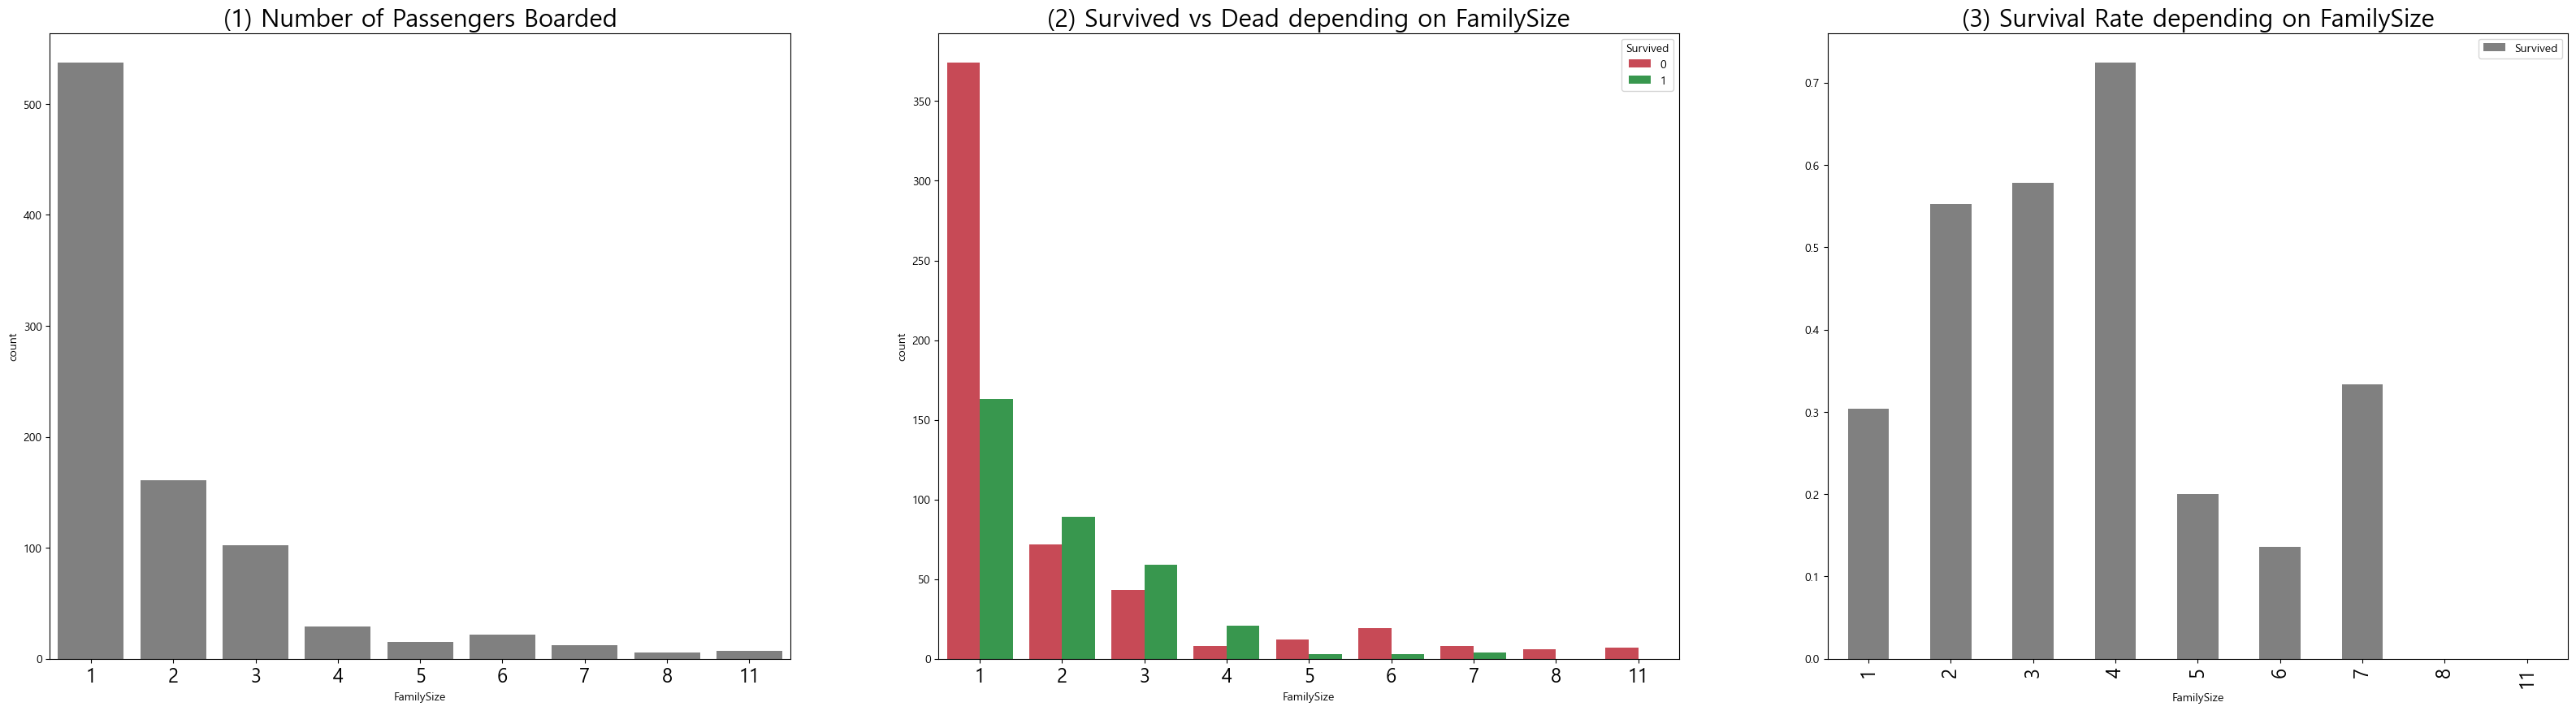

In [34]:
## 시각화
fig, ax = plt.subplots(1, 3, figsize=(40, 10))

sns.countplot(data=df_train, x='FamilySize', color='gray', ax=ax[0])
ax[0].set_title('(1) Number of Passengers Boarded', fontsize=22)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=17)

sns.countplot(data=df_train, x='FamilySize', hue='Survived', palette=['#dc3545', '#28a745'], ax=ax[1])
ax[1].set_title('(2) Survived vs Dead depending on FamilySize', fontsize=22)
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=17)

df_train[['FamilySize', 'Survived']].groupby('FamilySize').mean().plot.bar(color='gray', ax=ax[2])
ax[2].set_title('(3) Survival Rate depending on FamilySize', fontsize=22)
ax[2].set_xticklabels(ax[2].get_xticklabels(), fontsize=17)

plt.subplots_adjust(wspace=0.2)
plt.show()

Family 요약
- Figure 1 : 탑승자 대부분 혼자 탑승
- Figure 2 & 3 : 가족 구성원이 4명인 경우 생존률이 가장 높음, 가족수가 너무 작거나(1명) 너무 커도(5명~11명) 생존률이 낮아짐

## 2.8 Fare

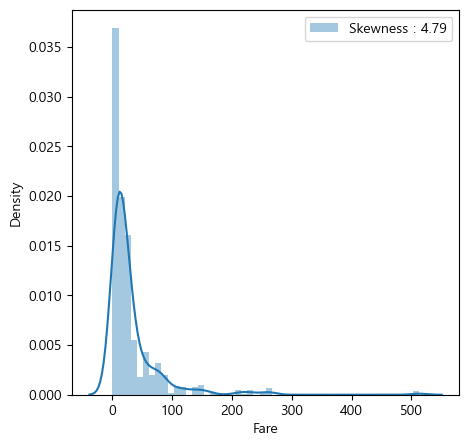

In [35]:
## Fare 시각화
fig, ax = plt.subplots(figsize=(5, 5))

# distplot = kde + 히스토그램
sns.distplot(df_train['Fare'], label='Skewness : {:.2f}'.format(df_train['Fare'].skew()))
plt.legend()

# 해석
# 비대칭적 구조 (high skewness)
# 몇 개 없는 이상치에 너무 민감하게 반응한다면 실제 예측 시 좋은 결과가 나타나기 어려움
# outlier의 영향을 줄이기 위해 Fare에 log 함수 적용
# 로그 변환은 데이터의 왜도 (skewness)를 줄이고, 값들이 큰 범위로 분포된 데이터를 다루기 쉽게 만듬

In [36]:
## Fare 결측치 처리
print('df_test 데이터셋의 Fare 결측값 수 : ', df_test['Fare'].isna().sum())

# 평균값으로 치환
df_test['Fare'].fillna(df_test['Fare'].mean(), inplace=True)

# 확인
print('df_test 데이터셋의 Fare 결측값 수 : ', df_test['Fare'].isna().sum())

df_test 데이터셋의 Fare 결측값 수 :  1
df_test 데이터셋의 Fare 결측값 수 :  0


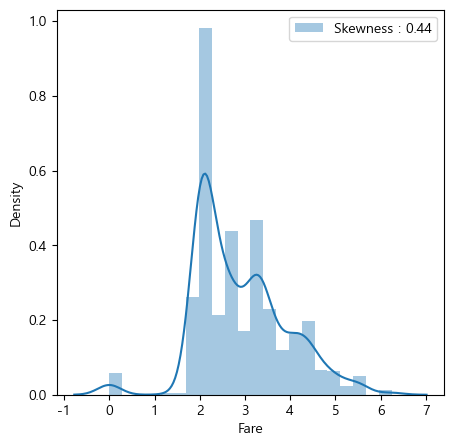

In [37]:
## Fare 시각화 (로그 변환)

# map : 특정 colum에 공통된 함수 적용
df_train['Fare'] = df_train['Fare'].map(lambda i : np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

fig, ax = plt.subplots(figsize=(5, 5))

sns.distplot(df_train['Fare'], label='Skewness : {:.2f}'.format(df_train['Fare'].skew()))
plt.legend()

## 2.9 Cabin

In [38]:
# 결측치 확인 → 모델 포함x
df_train['Cabin'].isna().sum() / len(df_train) * 100

77.10437710437711

## 2.10 Ticket

In [39]:
df_train['Ticket'].value_counts().sort_values(ascending=False).head(10)

Ticket
347082          7
1601            7
CA. 2343        7
3101295         6
CA 2144         6
347088          6
S.O.C. 14879    5
382652          5
4133            4
347077          4
Name: count, dtype: int64

# 3. Feature Engineering

실제 모델의 학습에 쓰려고 하는 것이기 때문에 train 뿐만 아니라 test에도 똑같이 적용

## 3.1 결측치 채우기

In [40]:
# df_train
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamilySize       0
dtype: int64

In [41]:
# df_test
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
FamilySize       0
dtype: int64

### 3.1.1 Age
- train, test 데이터에 존재
- IDEA : Name에 있는 Title(ex. Miss, Mr, Mrs)과 df_train의 통계량 활용

In [42]:
df_train['Name'].unique()

array(['Braund, Mr. Owen Harris',
       'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
       'Heikkinen, Miss. Laina',
       'Futrelle, Mrs. Jacques Heath (Lily May Peel)',
       'Allen, Mr. William Henry', 'Moran, Mr. James',
       'McCarthy, Mr. Timothy J', 'Palsson, Master. Gosta Leonard',
       'Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)',
       'Nasser, Mrs. Nicholas (Adele Achem)',
       'Sandstrom, Miss. Marguerite Rut', 'Bonnell, Miss. Elizabeth',
       'Saundercock, Mr. William Henry', 'Andersson, Mr. Anders Johan',
       'Vestrom, Miss. Hulda Amanda Adolfina',
       'Hewlett, Mrs. (Mary D Kingcome) ', 'Rice, Master. Eugene',
       'Williams, Mr. Charles Eugene',
       'Vander Planke, Mrs. Julius (Emelia Maria Vandemoortele)',
       'Masselmani, Mrs. Fatima', 'Fynney, Mr. Joseph J',
       'Beesley, Mr. Lawrence', 'McGowan, Miss. Anna "Annie"',
       'Sloper, Mr. William Thompson', 'Palsson, Miss. Torborg Danira',
       'Asplund, Mrs. Carl Oscar 

In [43]:
## Title 추출

# 정규 표현식 : 문자열에서 특정한 형태의 데이터를 검색, 매칭, 추출 또는 치환
# str.extract는 기본적으로 첫 번째 매칭만 반환

# 첫 번째로 발견되는 알파벳 대문자+소문자로 이루어진 문자열을 추출하고
# 마침표(.)로 끝나는 경우를 반환
df_train['Initial'] = df_train['Name'].str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test['Name'].str.extract('([A-Za-z]+)\.')

In [44]:
# 확인
display(df_train['Initial'].value_counts().head())
display(df_test['Initial'].value_counts().head())

Initial
Mr        517
Miss      182
Mrs       125
Master     40
Dr          7
Name: count, dtype: int64

Initial
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Name: count, dtype: int64

In [45]:
# Initial과 Sex의 corsstab (df_train)
pd.crosstab(df_train['Sex'], df_train['Initial']).style.background_gradient(cmap='GnBu')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [46]:
# male과 female이 사용하는 Initial 구분 (df_train)
df_train['Initial'].replace(['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess', 'Jonkheer']
                            , ['Mr', 'Other', 'Mr', 'Miss', 'Miss', 'Mr', 'Mrs', 'Mr', 'Miss', 'Other', 'Mr', 'Mrs', 'Other'], inplace=True)

# 확인
df_train['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

In [47]:
# Initial과 Sex의 crosstab (df_test)
pd.crosstab(df_test['Sex'], df_test['Initial']).style.background_gradient(cmap='GnBu')

Initial,Col,Dona,Dr,Master,Miss,Mr,Mrs,Ms,Rev
Sex,,,,,,,,,
female,0,1,0,0,78,0,72,1,0
male,2,0,1,21,0,240,0,0,2


In [48]:
# male과 female이 사용하는 Initial 구분 (df_test)
df_test['Initial'].replace(['Ms', 'Col', 'Rev', 'Dr', 'Dona']
                           , ['Miss', 'Other', 'Other', 'Mr', 'Miss'], inplace=True)

# 확인
df_test['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], dtype=object)

<Axes: xlabel='Initial'>

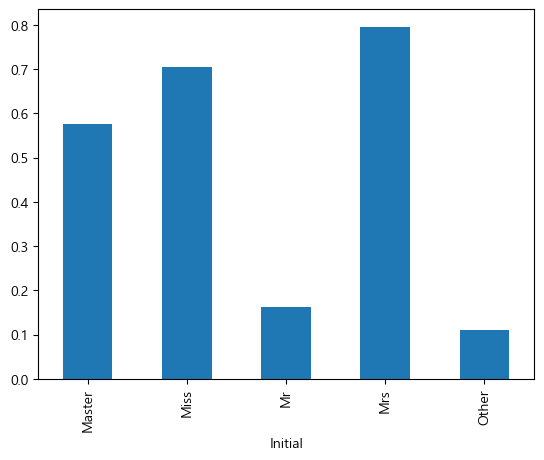

In [49]:
# 시각화
df_train.groupby('Initial')['Survived'].mean().plot.bar()

In [50]:
## Initial별 수치형 변수 평균값

# 수치형 변수 리스트
cols = []

for i in df_train.columns :
    if df_train[i].dtypes in ['int64', 'float64'] :
        cols.append(i)

# 확인
df_train.groupby('Initial')[cols].mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


In [51]:
## Age 칼럼 null 처리

# df_train에서 얻은 statistics를 기반으로 train과 test의 null 채우기
# Age의 평균을 이용

df_train.loc[(df_train['Age'].isna()) & (df_train['Initial'] == 'Master'), 'Age'] = 5
df_train.loc[(df_train['Age'].isna()) & (df_train['Initial'] == 'Miss'), 'Age'] = 22
df_train.loc[(df_train['Age'].isna()) & (df_train['Initial'] == 'Mr'), 'Age'] = 33
df_train.loc[(df_train['Age'].isna()) & (df_train['Initial'] == 'Mrs'), 'Age'] = 36
df_train.loc[(df_train['Age'].isna()) & (df_train['Initial'] == 'Other'), 'Age'] = 46

df_test.loc[(df_test['Age'].isna()) & (df_test['Initial'] == 'Master'), 'Age'] = 5
df_test.loc[(df_test['Age'].isna()) & (df_test['Initial'] == 'Miss'), 'Age'] = 5
df_test.loc[(df_test['Age'].isna()) & (df_test['Initial'] == 'Mr'), 'Age'] = 5
df_test.loc[(df_test['Age'].isna()) & (df_test['Initial'] == 'Mrs'), 'Age'] = 5
df_test.loc[(df_test['Age'].isna()) & (df_test['Initial'] == 'Other'), 'Age'] = 5

In [52]:
# 결측치 확인
print('df_train의 Age 결측치 개수 : ', df_train['Age'].isna().sum())
print('df_test의 Age 결측치 개수 : ', df_test['Age'].isna().sum())

df_train의 Age 결측치 개수 :  0
df_test의 Age 결측치 개수 :  0


### 3.1.2 Embarked
- train 데이터에만 존재

In [53]:
df_test['Embarked'].value_counts()

Embarked
S    270
C    102
Q     46
Name: count, dtype: int64

In [54]:
## Embarked 칼럼 null 처리

# S에 가장 많은 탑승객이 탑승했으므로 null값을 S로 대체
df_train['Embarked'].fillna('S', inplace=True)

# 확인
print('df_train의 Embarked 결측치 개수 : ', df_train['Embarked'].isna().sum())

df_train의 Embarked 결측치 개수 :  0


In [55]:
# 최종 결측치 확인
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
FamilySize       0
Initial          0
dtype: int64

In [56]:
df_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
FamilySize       0
Initial          0
dtype: int64

## 3.2 Age 타입 변환 (Continuous → Categorical)

In [57]:
# Age는 연속형 변수이지만 몇 개의 group으로 나누어 category화 가능
# 단, continuous 데이터를 categorical로 바꾸면 정보 손실이 생길 수 있음
df_train['Age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
891 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


In [58]:
## 10살 간격으로 Grouping

# apply 함수 사용
def category_age(x) : 
    if x < 10 :
        return 0
    elif x < 20 :
        return 1
    elif x < 30 :
        return 2
    elif x < 40 :
        return 3
    elif x < 50 :
        return 4
    elif x < 60 :
        return 5
    elif x < 70 :
        return 6
    else :
        return 7
    
# 함수 적용
df_train['Age_cat'] = df_train['Age'].apply(category_age)
df_test['Age_cat'] = df_test['Age'].apply(category_age)

# 확인
print('df_train의 Age_cat : {} / {}'.format(df_train['Age_cat'].unique(), df_train['Age_cat'].nunique()))
print('df_test의 Age_cat : {} / {}'.format(df_test['Age_cat'].unique(), df_test['Age_cat'].nunique()))

df_train의 Age_cat : [2 3 5 0 1 4 6 7] / 8
df_test의 Age_cat : [3 4 6 2 1 0 5 7] / 8
